In [16]:
%matplotlib inline
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy import sqrt, sin, cos, pi, cosh, sinh, tanh, exp, linalg, log
from sympy import symbols, solve
import math
from  scipy.sparse.linalg import eigs

def principal_eigenvector (matrix):
    N = matrix.shape[0]
    values, vectors = eigs(matrix, k = 1, which = 'LR')
    result = vectors[:, 0]
    result *= np.sqrt(N) 
    return result.reshape((N, 1))

def principal_eigenvalue(matrix):
    values, vectors = eigs(matrix, k = 1, which = 'LR')
    return values[0]

def get_overlap(truth, estimate):
    truth = truth.flatten()
    estimate = estimate.flatten()
    return max(np.dot(truth, estimate), np.dot(truth, -estimate)) / np.linalg.norm(truth) / np.linalg.norm(estimate)

def get_overlaps(truth, estimate):
    truth = truth.flatten()
    estimate = estimate.flatten()
    index = 0
    overlaps = []
    for size in sizes:
        overlaps.append(get_overlap(truth[index:index + size], estimate[index:index + size]))
        index += size
    return overlaps

def total_overlap(overlaps):
    total_overlap = 0
    for proportion, overlap in zip(proportions, overlaps):
        total_overlap += proportion * overlap
    return total_overlap

def create_block_matrix(sizes, block_delta):  
    blocks_belonging = []
    for current_block in range(len(sizes)):
        size = sizes[current_block]
        blocks_belonging += [current_block] * size
        
    delta = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            i_block, j_block = blocks_belonging[i], blocks_belonging[j]
            delta[i][j] = block_delta[i_block][j_block]
    return delta

def get_instance(dimension, prior, delta):
    if prior == 'gaussian':
        true_vector = np.random.normal(0,1, size = (dimension, 1))    
    elif prior == 'rademacher':
        true_vector = np.random.choice([-1,1], size = (dimension, 1))
        
    noise = np.triu(np.random.normal(0, 1, (dimension,dimension)))
    noise = noise + noise.T + np.diag(np.random.normal(0,1, dimension))
    
    corrupted_matrix = np.sqrt(1 / dimension) * true_vector @ true_vector.T + noise * np.sqrt(delta)

    return true_vector, corrupted_matrix

In [17]:
def denoiser_and_derivative(to_denoise):
    return to_denoise / np.linalg.norm(to_denoise)

def iterate_state_evolution(overlaps, variances, block_delta):
    overlaps, variances = np.array(overlaps), np.array(variances)
   
    matrix = (1 / block_delta) @ np.diag(proportions)
    new_overlaps = matrix @ overlaps
    new_variances = matrix @ (overlaps**2) + matrix @ variances
    return new_overlaps, new_variances

def linear_amp(precision = 1e-3, max_steps = 100, *, init, Y, delta, truth):
    
    previous_estimator = np.zeros((N, 1))
    estimator = np.copy(init)
    
    se_overlaps = get_overlaps(init, truth)
    se_variances = get_overlaps(init, init)
    for timestep in range(max_steps):   
        Onsager_term = ((1/delta) @ np.ones(N)) / N
        next_step = np.sqrt(1 / N) * (Y/delta) @ estimator - Onsager_term * previous_estimator 
        
        previous_estimator = np.copy(estimator)
        estimator = next_step / np.linalg.norm(next_step)
        se_overlaps, se_variances = iterate_state_evolution(se_overlaps, se_variances, block_delta * delta[0][0])
        
        step_difference = np.mean((estimator-previous_estimator)**2)
    
    vector = proportions * (se_overlaps**2 + se_variances)
    normalisation = np.sqrt(np.sum(vector))
    return estimator, total_overlap(se_overlaps / normalisation)

In [18]:
def averaged_performance(seeds = 20, initialisation = 'uninformed', *, delta, algorithm):
 
    overlaps, state_evolution_overlaps = [], []
    for _ in range(seeds):
        
        truth, Y = get_instance(dimension = N, prior = prior, delta = delta)
        Onsager_approximate = np.array([np.sum(1 / delta[j]) for j in range(N)]) / N
        spectral_estimate = principal_eigenvector(Y / np.sqrt(N) / delta - np.diag(Onsager_approximate))
        if algorithm == 'spectral':
        
        else:
            if initialisation == 'informed':
                init = truth 
            elif initialisation == 'spectral':
                init = spectral_estimate
            else:
                init = 1e-3 * np.random.normal(0,1,(N,1)) 
        estimate, se_overlap = linear_amp(init = init, Y = Y, delta = delta, truth = truth)
        overlaps.append(get_overlap(truth, estimate))
        state_evolution_overlaps.append(se_overlap)
            
    return np.mean(overlaps), np.mean(state_evolution_overlaps)

In [19]:
def data():
#Returns an array of mse for given levels of noise, algorithm can be AMP or spectral
    data = {'operator_norm' : [], 'overlap': [], 'state_evolution': []}
    
    parameter_range = np.linspace(start, end, points)
    for parameter in parameter_range:
        print("Computing with parameter = {}".format(parameter))
        delta = create_block_matrix(sizes, parameter * block_delta)
        overlap, se_overlap = averaged_performance(delta = delta)
        matrix = np.diag(np.sqrt(proportions)) @ (1 / (parameter * block_delta)) @ np.diag(np.sqrt(proportions))
        data['operator_norm'].append(principal_eigenvalue(matrix))
        data['overlap'].append(overlap)
        data['state_evolution'].append(se_overlap)
    return data

def visualize ():
#plotting function
    fig, ax = plt.subplots(figsize = (8,6))
    plt.plot(data['operator_norm'], data['overlap'], 
         '.', label = 'overlap', color = 'red')
    plt.plot(data['operator_norm'], data['state_evolution'],
             '.', label = 'SE_overlap', color = 'purple')
        
    plt.xlabel('operator_norm')
    plt.ylabel('overlap')
    plt.legend()
    plt.show()

Computing with parameter = 0.2
Computing with parameter = 0.22758620689655173
Computing with parameter = 0.25517241379310346
Computing with parameter = 0.2827586206896552
Computing with parameter = 0.3103448275862069
Computing with parameter = 0.33793103448275863
Computing with parameter = 0.3655172413793104
Computing with parameter = 0.3931034482758621
Computing with parameter = 0.42068965517241386
Computing with parameter = 0.4482758620689655
Computing with parameter = 0.4758620689655173
Computing with parameter = 0.5034482758620691
Computing with parameter = 0.5310344827586208
Computing with parameter = 0.5586206896551724
Computing with parameter = 0.5862068965517242
Computing with parameter = 0.613793103448276
Computing with parameter = 0.6413793103448276
Computing with parameter = 0.6689655172413793
Computing with parameter = 0.6965517241379311
Computing with parameter = 0.7241379310344829
Computing with parameter = 0.7517241379310347
Computing with parameter = 0.7793103448275862


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


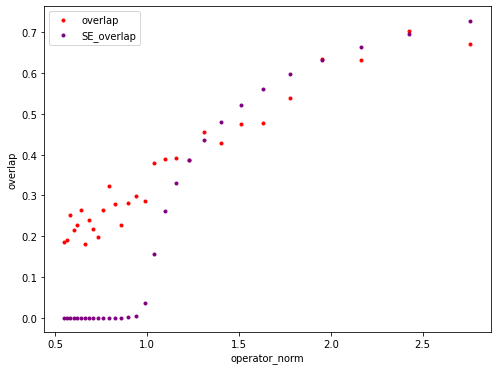

In [20]:
N = 100 #initializing dimension

start = 0.2 #from small noise
end = 1  #to big one
points = 30 #number of different levels of noise to visualize in the range

prior = 'gaussian' # 'gaussian' or 'rademacher'
x_axis = 'operator_norm' #'operator_norm' or 'parameter'
y_axis = 'overlap'#'mse' or 'overlap'#

proportions = [0.5, 0.5] #proportions of blocks respectively, number of blocks can be arbitrary
sizes = [int(N * proportion) for proportion in proportions]
sizes[-1] += (N - sum(sizes)) #sum of sizes should be always equal to N

block_delta = np.array([[1, 4], [4, 2]]) #2*2 matrix encoding the block structure 

visualize(data(prior))